This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to Keras and TensorFlow

## What's TensorFlow?

## What's Keras?

## Keras and TensorFlow: A brief history

## Setting up a deep-learning workspace

### Jupyter notebooks: The preferred way to run deep-learning experiments

### Using Colaboratory

#### First steps with Colaboratory

#### Installing packages with pip

#### Using the GPU runtime

## First steps with TensorFlow

#### Constant tensors and variables

**All-ones or all-zeros tensors**

In [15]:
import tensorflow as tf #TensorFlow 버전 행렬 만들기
x = tf.ones(shape=(2, 1)) #2행 1열짜리 원소 1만 가지는 Matrices
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [3]:
x = tf.zeros(shape=(2, 1)) #2행 1열짜리 원소 0만 가지는 Matrices
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Random tensors**

In [4]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.) # N(0,1)을 따르는 원소 랜덤 추출 후 3행 1열 Matrices 만듦
print(x)

tf.Tensor(
[[1.6323872]
 [1.6332383]
 [1.096591 ]], shape=(3, 1), dtype=float32)


In [7]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.) #0 이상 1 이하의 원소로 채워넣음
print(x)

tf.Tensor(
[[0.16761029]
 [0.49351037]
 [0.20908105]], shape=(3, 1), dtype=float32)


**NumPy arrays are assignable**

In [10]:
import numpy as np #np 버전 행렬 만들기
x = np.ones(shape=(2, 2))
x[0, 0] = 0. #1행 1열 (0번 인덱스 = 1) 원소를 0으로 고정
print(x)

[[0. 1.]
 [1. 1.]]


**Creating a TensorFlow variable**

In [20]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1))) #기존 TensorFlow 변수는 assignable하지 않아 원소를 바꾸는 것이 불가능
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.26860717],
       [-0.6775783 ],
       [ 0.5522478 ]], dtype=float32)>


**Assigning a value to a TensorFlow variable**

In [26]:
v.assign(tf.ones((3, 1))) #v.assign 함수를 통해 원소 변경 가능

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Assigning a value to a subset of a TensorFlow variable**

In [27]:
v[0, 0].assign(3.) #v[i,j].assign() 함수를 통해 특정 원소만 변경

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Using `assign_add`**

In [28]:
v.assign_add(tf.ones((3, 1))) # 3행 1열짜리 1뿐인 행렬을 v에다가 더함

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow

**A few basic math operations**

In [30]:
a = tf.ones((2, 2)) #원소 다 1인 Matrices로 지정
b = tf.square(a) #원소 모두 제곱
c = tf.sqrt(a) #원소 모두 근호 씌움
d = b + c #두 행렬 덧셈
e = tf.matmul(a, b) #두 행렬 곱셉
e *= d #행렬 곱한 값 적용 -> e를 ed로 변환

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32) tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32) tf.Tensor(
[[4. 4.]
 [4. 4.]], shape=(2, 2), dtype=float32)


#### A second look at the GradientTape API

**Using the `GradientTape`**

In [39]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape: #result : y, input_var : x로 보면 편함
   result = tf.square(input_var) # y=x^2 고급스럽게 표현함
gradient = tape.gradient(result, input_var) # dy/dx
print(gradient) #y=2x에 x=3 (initial_value = 3.) 대입한 값인 6 나옴

tf.Tensor(6.0, shape=(), dtype=float32)


**Using `GradientTape` with constant tensor inputs**

In [37]:
input_const = tf.constant(3.) #상수 (변수가 아님)
with tf.GradientTape() as tape:
   tape.watch(input_const) #상수를 변수로 변환
   result = tf.square(input_const) #y=x^2
gradient = tape.gradient(result, input_const) #변환 안 하고 미분하면 None 뜸 (상수로는 미분이 불가능하므로)
print(gradient) # 마찬가지로 input_const=3.이므로 y=2x에 3 대입한 값인 6 나옴

tf.Tensor(6.0, shape=(), dtype=float32)


**Using nested gradient tapes to compute second-order gradients**

In [ ]:
#수업 시간에 안 함
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [44]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], #(0,3) 기준으로 주변으로 흩어짐
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class) #표본 개수는 1000개 (맨 윗줄에서 1000개로 지정했음) -> sample은 1000행 2열
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], #(3, 0) 기준으로 주변으로 흩어짐
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [45]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
#np.vstack : 두 행렬을 세로로 합침

In [50]:
a=np.ones((2,1))
b=np.zeros((2,1))
np.vstack((a,b))
#두 행렬을 행 방향으로 합침

array([[1.],
       [1.],
       [0.],
       [0.]])

**Generating the corresponding targets (0 and 1)**

In [51]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"), #1000행 1열짜리 원소 0뿐인 Matrices
                     np.ones((num_samples_per_class, 1), dtype="float32"))) #1000행 1열짜리 원소 1뿐인 Matrices
#np.vstack으로 두 행렬 합침 (2000행 1열로 만듦)

**Plotting the two point classes**

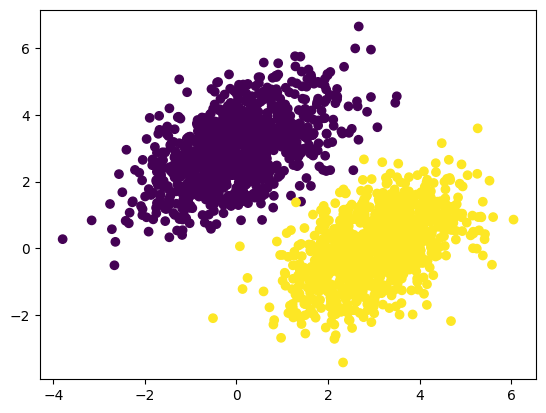

In [52]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0]) #(0,3) 및 (3,0)을 중심으로 잘 모여있음을 확인
plt.show()

**Creating the linear classifier variables**

In [55]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim))) # X와 W의 차원은 2차원, X * W의 값은 1차원이 되도록 함 (X에 x와 y가 있고 W에 w_1, w_2가 있음)
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,))) # b의 값도 1차원으로 설정 (연산 결과 w_1 * x + w_2 * y + b로 나옴)

**The forward pass function**

In [56]:
def model(inputs): # x 대입하면 Wx+b 주겠다는 말
    return tf.matmul(inputs, W) + b

**The mean squared error loss function**

In [57]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions) # [(참값) - (예측치)]^2
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [58]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs) #model(inputs)은 윗윗칸에서 W * x + b로 정의함
        loss = square_loss(targets, predictions) #square_loss는 바로 윗칸에서 [참값-예측치]^2로 정의함
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b]) #dl/dW와 dl/db의 값 순차적으로 계산
    W.assign_sub(grad_loss_wrt_W * learning_rate) #dl/dW의 값에 0.1 (learning rate) 곱함
    b.assign_sub(grad_loss_wrt_b * learning_rate) #dl/db의 값에 0.1 (learning rate) 곱함
    return loss

**The batch training loop**

In [59]:
for step in range(40):
    loss = training_step(inputs, targets) #Wx+b로 두고 loss 구하고 dl/dW, dl/db 구하고 0.1씩 곱하는 과정 과정 싹 다 포함
    print(f"Loss at step {step}: {loss:.4f}") #스텝마다 loss의 값 계산 (점점 줄어듦이 보임)

Loss at step 0: 3.3718
Loss at step 1: 0.4955
Loss at step 2: 0.1812
Loss at step 3: 0.1240
Loss at step 4: 0.1083
Loss at step 5: 0.0999
Loss at step 6: 0.0931
Loss at step 7: 0.0870
Loss at step 8: 0.0816
Loss at step 9: 0.0766
Loss at step 10: 0.0720
Loss at step 11: 0.0678
Loss at step 12: 0.0640
Loss at step 13: 0.0605
Loss at step 14: 0.0574
Loss at step 15: 0.0545
Loss at step 16: 0.0519
Loss at step 17: 0.0495
Loss at step 18: 0.0473
Loss at step 19: 0.0453
Loss at step 20: 0.0434
Loss at step 21: 0.0418
Loss at step 22: 0.0403
Loss at step 23: 0.0389
Loss at step 24: 0.0376
Loss at step 25: 0.0365
Loss at step 26: 0.0354
Loss at step 27: 0.0344
Loss at step 28: 0.0336
Loss at step 29: 0.0328
Loss at step 30: 0.0320
Loss at step 31: 0.0314
Loss at step 32: 0.0308
Loss at step 33: 0.0302
Loss at step 34: 0.0297
Loss at step 35: 0.0292
Loss at step 36: 0.0288
Loss at step 37: 0.0284
Loss at step 38: 0.0281
Loss at step 39: 0.0278


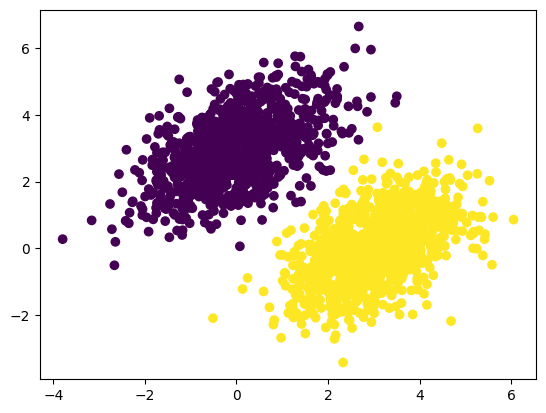

In [60]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

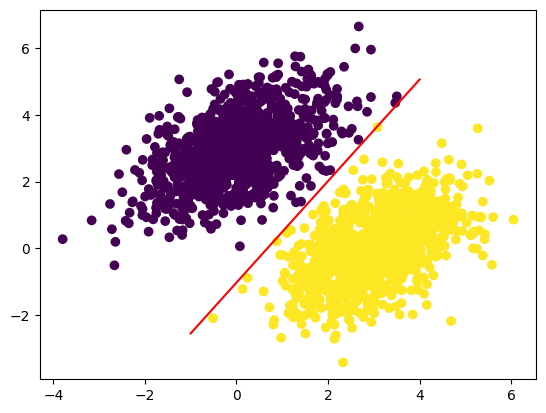

In [61]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1] # W_1 * x + W_2 * y + b = 0.5를 y에 대해 정의한 것
plt.plot(x, y, "-r") #빨간색 선 추가
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [62]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None): #변수 지정, 여기서 units은 output 성분에 해당한다고 생각하면 편함
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1] #뒤에서 1등 (마지막 원소, 즉 0번에서 n번 인덱스까지 있다면 -1번 인덱스 = n번 인덱스)
        self.W = self.add_weight(shape=(input_dim, self.units), # x가 1 * i 행렬이면 W는 i * j 행렬
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,), # x * W가 1 * j 행렬이므로 b도 j 행렬
                                 initializer="zeros") #편차는 0으로 고정

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b # Wx+b를 의미
        if self.activation is not None:
            y = self.activation(y)
        return y

In [63]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu) #32열짜리 결과가 나와야 함
input_tensor = tf.ones(shape=(2, 784)) #2행 784열짜리 투입
output_tensor = my_dense(input_tensor) #my_Dense는 SimpleDense(Units = 32)로 정의된 상태
print(output_tensor.shape) #unit 32로 정하고 W * x + b (b=0이니 W * x로 봐도 됨)의 행렬 크기를 알려줌 W : (2*784(input_dim)) * x : (784(input_dim)*32) = 2행 32열

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [64]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [65]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [66]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])
#Ch.2에서 naive_Dense를 만들 때에는 input, Output이 얼마인지 모두 설정했으나, SimpleDense에서는 Units만 설정하여 원하는 Output값이 나오도록 input값 자동 조정

### From layers to models

### The "compile" step: Configuring the learning process

In [68]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [69]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [70]:
history = model.fit(
    inputs,
    targets,
    epochs=5, #training loop 반복 횟수
    batch_size=128
)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.1678 - loss: 2.7740
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.1664 - loss: 2.6718  
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.1783 - loss: 2.4714 
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.2063 - loss: 2.3010 
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.2056 - loss: 2.2201 


In [71]:
history.history

{'binary_accuracy': [0.15700000524520874,
  0.17249999940395355,
  0.18449999392032623,
  0.19949999451637268,
  0.21549999713897705],
 'loss': [2.8121535778045654,
  2.6149771213531494,
  2.4518558979034424,
  2.295766592025757,
  2.1481940746307373]}

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

In [73]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8769 - loss: 0.2715 - val_binary_accuracy: 0.9833 - val_loss: 0.0798
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9586 - loss: 0.0662 - val_binary_accuracy: 0.8233 - val_loss: 0.1847
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9563 - loss: 0.0736 - val_binary_accuracy: 0.9267 - val_loss: 0.1017
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9527 - loss: 0.0741 - val_binary_accuracy: 0.9950 - val_loss: 0.0249
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9549 - loss: 0.0759 - val_binary_accuracy: 0.9950 - val_loss: 0.0414


### Inference: Using a model after training

In [74]:
predictions = model.predict(val_inputs, batch_size=128) #batch_size를 설정해주어 조금씩 모든 데이터 검정하도록 함
print(predictions[:10])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[ 0.73080975]
 [ 0.79845166]
 [ 0.76275486]
 [-0.42493808]
 [-0.19289696]
 [-0.314506  ]
 [ 0.0793744 ]
 [-0.20194578]
 [ 0.8665691 ]
 [ 0.84856296]]


## Summary